In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np
from opt_einsum import contract

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v


In [ ]:
psi

In [65]:
Be = psi4.geometry( 
""" 
0 1
Kr
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf",
                  "dft_radial_points" : "500"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole moments instead.
wfn = psi4.properties("svwn/aug-cc-pvtz",  return_wfn=True, molecule=Be, property=['dipole'])[1]

In [66]:
# Build inverter and set target
ibe = n2v.Inverter(wfn)

# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ibe.invert("WuYang", guide_potential_components=["fermi_amaldi"], opt_tol=1e-5)

Optimization Successful within 5 iterations! |grad|=8.92e-06


In [67]:
x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grids = np.array([x,y,z])
grids.shape

(3, 101)

In [68]:
xyzw = ibe.generate_dft_grid(wfn)

In [69]:
density = ibe.on_grid_density(grid=xyzw)

In [70]:
np.ceil(np.sum(density[:,0] *  xyzw[3,:]))

18.0

In [71]:
def _get_l_kinetic_energy_density_directly(wfn, D, C, grid_info=None):
        """
        Calculate $\frac{\tau_L^{KS}}{\rho^{KS}}-\frac{\tau_P^{KS}}{\rho^{KS}}$,
        (i.e. the 2dn and 3rd term in eqn. (17) in [1]):
        """
        
        Vpot = wfn.V_potential()

        if grid_info is None:
            tauLmP_rho = np.zeros(Vpot.grid().npoints())
            nblocks = Vpot.nblocks()

            points_func = Vpot.properties()[0]
            blocks = None

        else:
            blocks, npoints, points_func = grid_info
            tauLmP_rho = np.zeros(npoints)
            nblocks = len(blocks)
            gradient = np.zeros(npoints)

        points_func.set_deriv(2)

        iw = 0
        for l_block in range(nblocks):
            # Obtain general grid information
            if blocks is None:
                l_grid = Vpot.get_block(l_block)
            else:
                l_grid = blocks[l_block]
            l_npoints = l_grid.npoints()

            points_func.compute_points(l_grid)
            l_lpos = np.array(l_grid.functions_local_to_global())
            if len(l_lpos) == 0:
                iw += l_npoints
                continue
            l_phi = np.array(points_func.basis_values()["PHI"])[:l_npoints, :l_lpos.shape[0]]
            l_phi_x = np.array(points_func.basis_values()["PHI_X"])[:l_npoints, :l_lpos.shape[0]]
            l_phi_y = np.array(points_func.basis_values()["PHI_Y"])[:l_npoints, :l_lpos.shape[0]]
            l_phi_z = np.array(points_func.basis_values()["PHI_Z"])[:l_npoints, :l_lpos.shape[0]]
            l_phi_xx = np.array(points_func.basis_values()["PHI_XX"])[:l_npoints, :l_lpos.shape[0]]
            l_phi_yy = np.array(points_func.basis_values()["PHI_YY"])[:l_npoints, :l_lpos.shape[0]]
            l_phi_zz = np.array(points_func.basis_values()["PHI_ZZ"])[:l_npoints, :l_lpos.shape[0]]

            lD = D[(l_lpos[:, None], l_lpos)]
            rho = contract('pm,mn,pn->p', l_phi, lD, l_phi)

            # Calculate the second term 0.25*\nabla^2\rho
            laplace_rho_temp = contract('ab,pa,pb->p', lD, l_phi, l_phi_xx + l_phi_yy + l_phi_zz)
            laplace_rho_temp += np.sum((l_phi_x @ lD) * l_phi_x, axis=1)
            laplace_rho_temp += np.sum((l_phi_y @ lD) * l_phi_y, axis=1)
            laplace_rho_temp += np.sum((l_phi_z @ lD) * l_phi_z, axis=1)

#             laplace_rho_temp *= 0.25 * 2

            # Calculate the third term |nabla rho|^2 / 8
            tauW_temp  = contract('pm, mn, pn->p', l_phi, lD, l_phi_x) ** 2
            tauW_temp += contract('pm, mn, pn->p', l_phi, lD, l_phi_y) ** 2
            tauW_temp += contract('pm, mn, pn->p', l_phi, lD, l_phi_z) ** 2
#             tauW_temp *= rho_inv * 0.125 * 4

#             tauLmP_rho[iw: iw + l_npoints] = (-laplace_rho_temp + tauW_temp) * rho_inv
            tauLmP_rho[iw: iw + l_npoints] = laplace_rho_temp
            iw += l_npoints
        assert iw == tauLmP_rho.shape[0], "Somehow the whole space is not fully integrated."

        return tauLmP_rho


In [72]:
gradient = _get_l_kinetic_energy_density_directly(wfn=wfn, D=wfn.Da().np, C=wfn.Ca_subset("AO", "OCC").np)

In [73]:
gradient.shape

(21594,)

In [74]:
grad = []
zgrid = []
dens = []

for i in range(len(gradient)):
    if np.isclose(np.abs(xyzw[0][i]), 0.0):
        if np.isclose(np.abs(xyzw[1][i]), 0.0):
            grad.append( gradient[i] )
            zgrid.append( xyzw[2][i] )
            dens.append( density[i])
        
grad = np.array(grad)
zgrid = np.array(zgrid)
dens = np.array(dens)

ind = zgrid.argsort()
grad  = grad[ind]
zgrid    = zgrid[ind]
dens   = dens[ind]

In [75]:
grad.shape

(142,)

(0.0, 3.0)

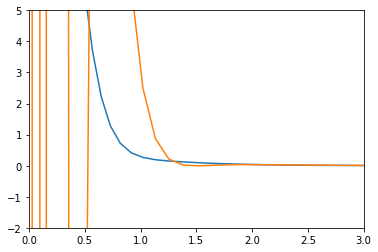

In [82]:
# plt.plot(zgrid,np.abs(grad)/(dens[:,0]**(5/3)))
plt.plot(zgrid, dens)
plt.plot(zgrid, grad)
plt.ylim(-2,5)
plt.xlim(0,3)

In [52]:
zgrid

array([-2.36045055e+01, -2.14489436e+01, -1.96789404e+01, -1.81751578e+01,
       -1.68665782e+01, -1.57075534e+01, -1.46670371e+01, -1.37229800e+01,
       -1.28591765e+01, -1.20633797e+01, -1.13261173e+01, -1.06399189e+01,
       -9.99879269e+00, -9.39786198e+00, -8.83310603e+00, -8.30117127e+00,
       -7.79923116e+00, -7.32488050e+00, -6.87605444e+00, -6.45096565e+00,
       -6.04805496e+00, -5.66595214e+00, -5.30344450e+00, -4.95945149e+00,
       -4.63300388e+00, -4.32322683e+00, -4.02932572e+00, -3.75057441e+00,
       -3.48630548e+00, -3.23590192e+00, -2.99879013e+00, -2.77443402e+00,
       -2.56232992e+00, -2.36200230e+00, -2.17300000e+00, -1.99489310e+00,
       -1.82727013e+00, -1.66973572e+00, -1.52190854e+00, -1.38341953e+00,
       -1.25391035e+00, -1.13303209e+00, -1.02044409e+00, -9.15812980e-01,
       -8.18811792e-01, -7.29119277e-01, -6.46419260e-01, -5.70400127e-01,
       -5.00754384e-01, -4.37178301e-01, -3.79371615e-01, -3.27037309e-01,
       -2.79881436e-01, -